In [ ]:
HTML(read(open("style.css"), String))

# Alpha-Beta Pruning
Alpha-Beta pruning is an optimization of the MiniMax algorithm, which is described in notebook MiniMax. The Minimax algorithm considers all possible moves and their effects on the game tree to find the best move for a player. However, this algorithm can be computationally intensive as it searches the entire game tree up to a certain depth.

Alpha-Beta pruning allows for a significant reduction in the search space by cutting off certain branches of the game tree early without having to analyze all possible moves. This is achieved by using two values, Alpha and Beta.

Alpha represents the best move found so far for the Max player, the player trying to maximize their score. It serves as a lower bound for the value that this player can achieve. On the other hand, Beta represents the best move found so far for the Min player, the player trying to minimize the score. It serves as an upper bound for the value that this player can achieve. During the search, the values of Alpha and Beta are updated to consider the best moves known so far for the players.

In the example, it becomes clear how Alpha-Beta pruning works. Starting with the assignment of the value 6 to state D, the upper bound of state B is also set to 6. This means that state E must be less than 6 to be considered as the best move.

In state E, the first leaf node is evaluated with a value of 9. Since the Max player now knows that they can achieve at least 9 points, the lower bound (Alpha) of state E is set to 9. Due to this update, the algorithm does not need to calculate any further leaf nodes from state E since a better result is already known. This result cannot be improved upon because there is no natural number that is both greater than 9 and smaller than 6.

A similar case occurs with state C. By evaluating state B, the lower bound is set to 6. State F sets the upper bound to 1. Since there is no natural number that is both greater than 6 and smaller than 1, the further sub-branches are not considered.


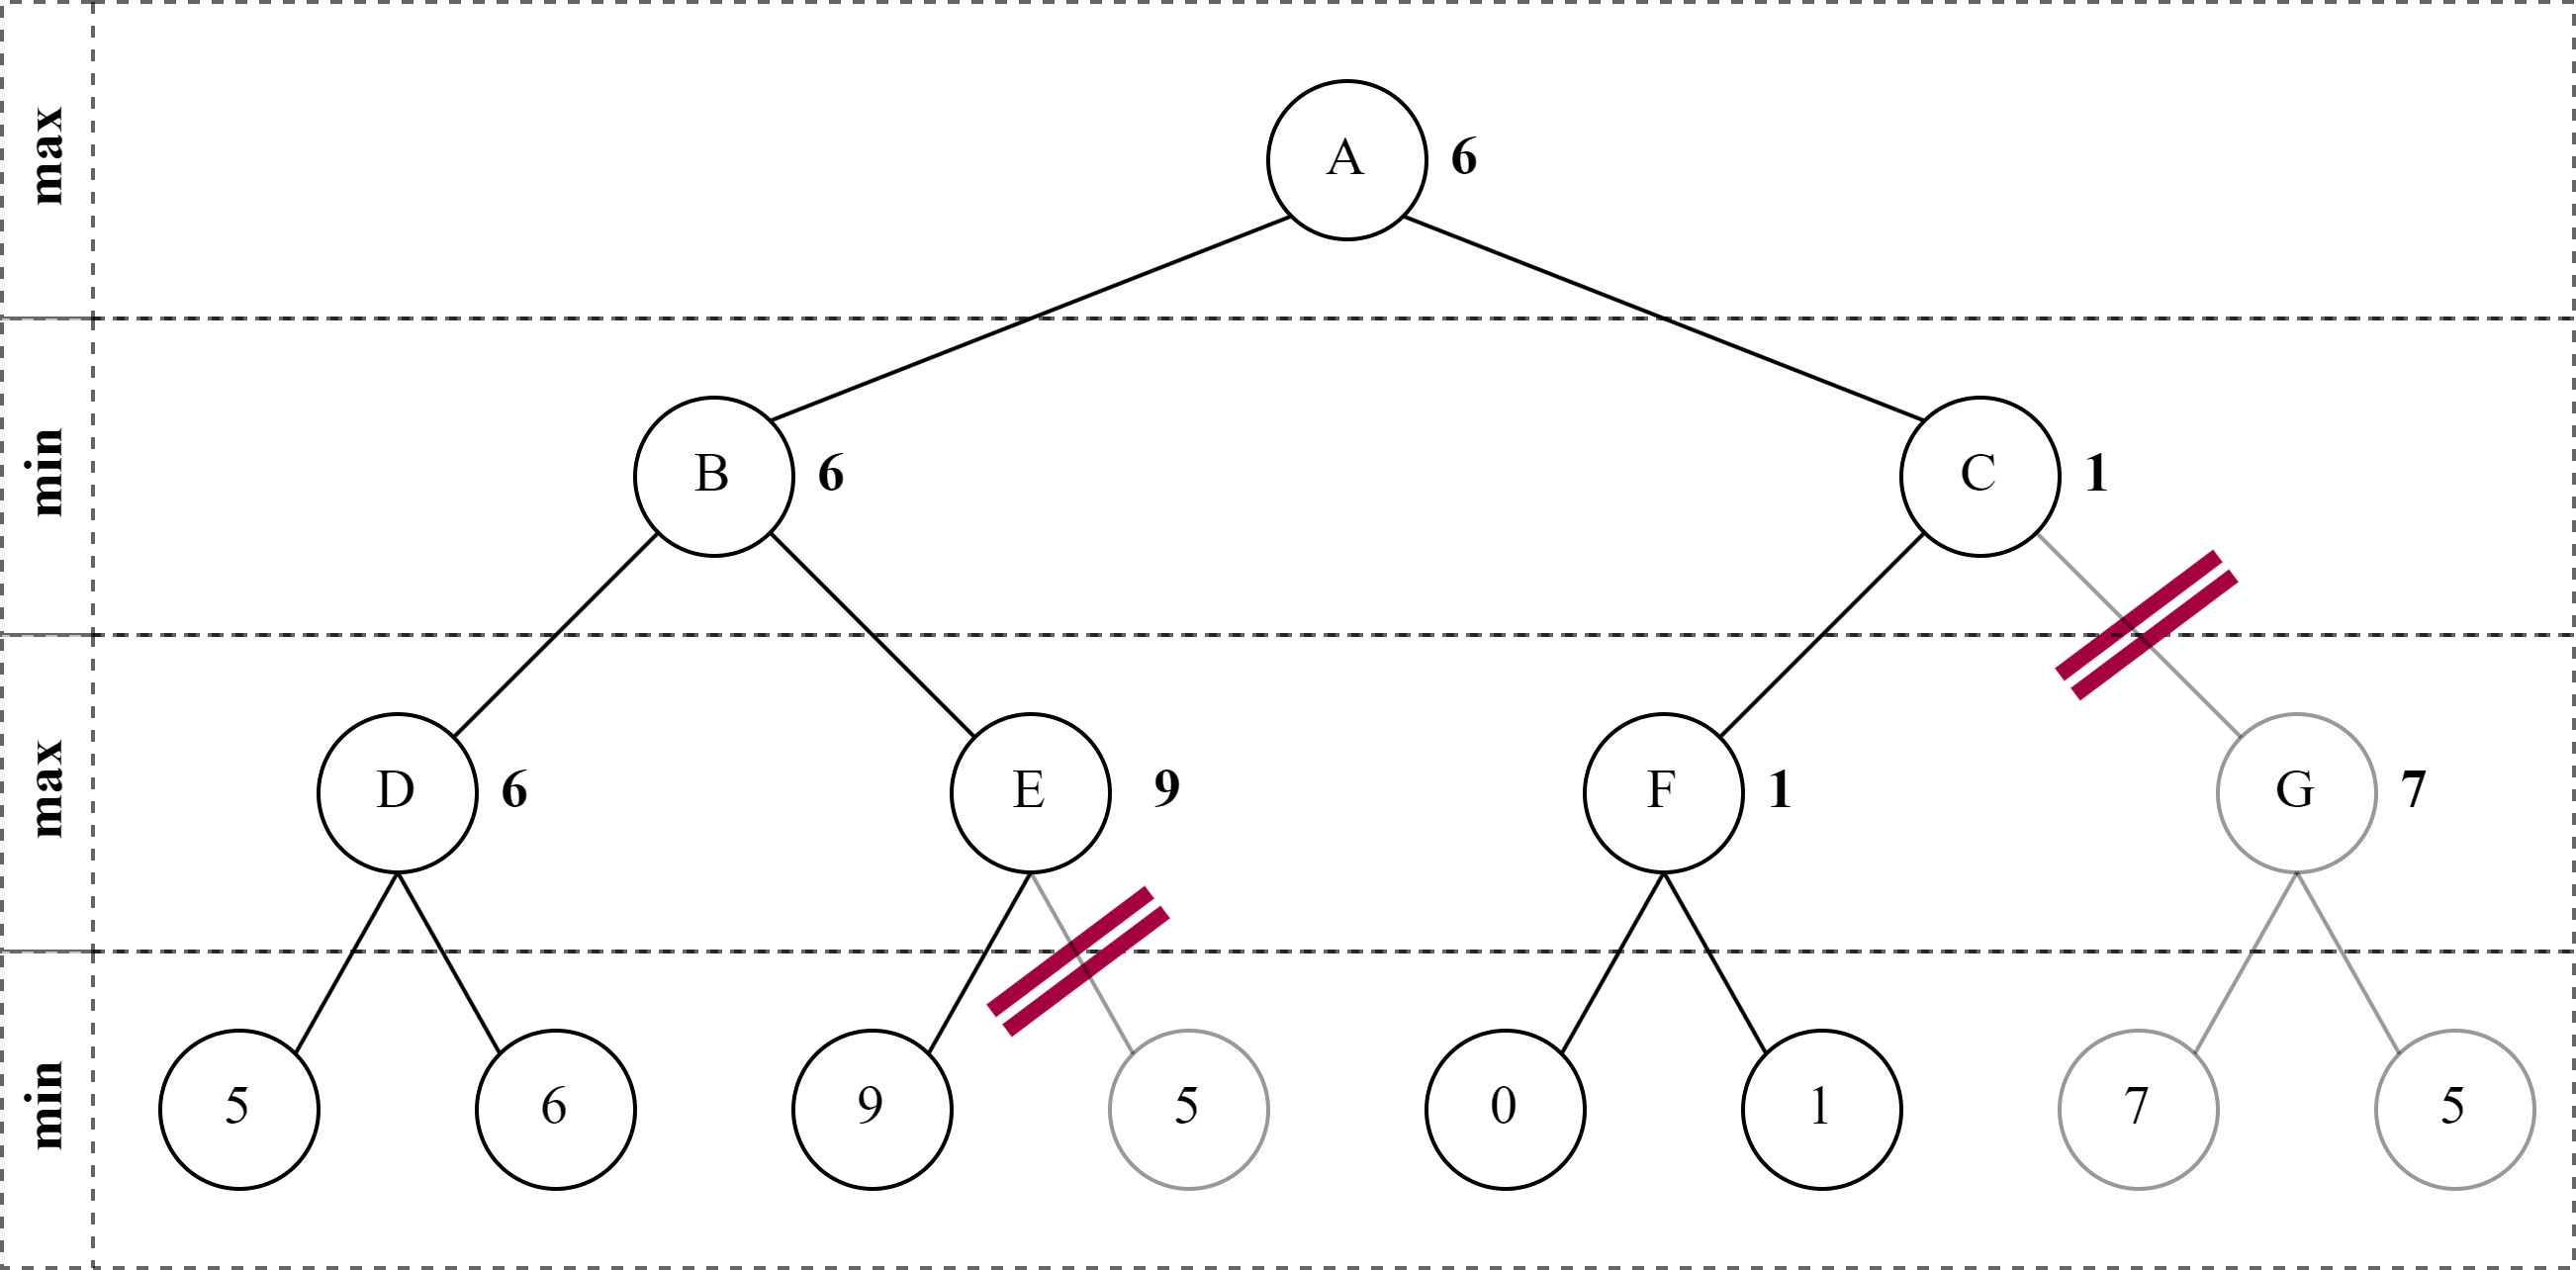

By using Alpha-Beta pruning, large portions of the game tree can be eliminated when they have no impact on the final decision. This leads to significant savings in computation time and allows the algorithm to search more efficiently for the best move.

The algorithm can be summarzied using the following equations. 

$ s \in states $

1. $\alpha \leq maxValue(s) \leq \beta \longrightarrow alphaBetaMax(s, \alpha, \beta) = maxValue(s)$
1. $maxValue(s) \lt \alpha \longrightarrow alphaBetaMax(s, \alpha, \beta) \leq \alpha$ 
1. $\beta \lt maxValue(s) \longrightarrow \beta \leq alphaBetaMax(s, \alpha, \beta)$ 


1. $\alpha \leq minValue(s) \leq \beta \longrightarrow alphaBetaMax(s, \alpha, \beta) = minValue(s)$ 
1. $minValue(s) \lt \alpha \longrightarrow alphaBetaMax(s, \alpha, \beta) \leq \alpha $ 
1. $\beta \lt minValue(s)\longrightarrow \beta \leq alphaBetaMax(s, \alpha, \beta)$ 

A comprehensive validation of this technique is presented in the work of Donald E. Knuth and Ronald W. Moore \cite{Knuth1975}, which provides further insight into the effectiveness of this algorithm.

In [ ]:
using Pkg
# Pkg.add("Chess")
using Chess
using Random

# Pkg.add("NBInclude")
using NBInclude

In [ ]:
@nbinclude("EvaluatePosition.ipynb")

In [ ]:
@nbinclude("AdvancedBoard.ipynb")

In [ ]:
@nbinclude("Memoization.ipynb")

## AlphaBetaMax

The `alphaBetaMax_noMem` function takes in 3 arguments and 2 optional arguments.

1. `aBoard::AdvBoard` is a chess board in the current state
1. `depth` is the number of halfmoves the engine should analyze before terminating 
1. `alpha` is optional and is default to -Infinity. Alpha is a minimal value that has been calculated during the recursive process
1. `beta`  is optional and is default to Infinity . Beta is a maximal value that has been calculated during the recursive process

The function returns the maximal centipawn evaluation of the current position for the player playing white where both players have played the optimal moves according to the algorithm and terminating after the given depth. This function does not use Memoization.

We will discuss the requirements for the alphaBetaMax function and how it satisfies these requirements:
- One of the requirements for the alphaBetaMax function is that it should compute the same result as the maxValue function when the maximum value of a node is between α and β. This means that:

$$\alpha \leq maxValue(s) \leq \beta \longrightarrow alphaBetaMax(s, \alpha, \beta) = maxValue(s)$$

This requirement ensures that the alphaBetaMax function does not prune any nodes that could potentially lead to the optimal solution.
- Another requirement for the alphaBetaMax function is that it should return a value less than or equal to α when the maximum value of a node is less than α. This means that:

$$maxValue(s) \lt \alpha \longrightarrow alphaBetaMax(s, \alpha, \beta) \leq \alpha$$

- The last requirement for the alphaBetaMax function is that it should return a value greater than or equal to β when the maximum value of a node is greater than β. This means that:

$$\beta \lt maxValue(s) \longrightarrow \beta \leq alphaBetaMax(s, \alpha, \beta)$$

In [ ]:
function alphaBetaMax_noMem(aBoard::AdvBoard, depth::Int64, alpha::Int64=-200000, beta::Int64=200000)::Int64
    if isterminal(aBoard.state)
        return terminal_evaluation(aBoard) - depth
    end
    if depth == 0
        return aBoard.score
    end
    for move in moves(aBoard.state)
        Undo = domoveAdv!(aBoard, move)
        value = alphaBetaMin_noMem(aBoard, depth - 1, alpha, beta)
        undomoveAdv!(aBoard, Undo)
        if value >= beta
            return value
        end
        alpha = max(alpha, value)
    end
    return alpha
end

## AlphaBetaMin

The `alphaBetaMin_noMem` function takes in 3 arguments and 2 optional arguments.

1. `aBoard::AdvBoard` is a chess board in the current state
1. `depth` is the number of halfmoves the engine should analyze before terminating 
1. `alpha` is optional and is default to -Infinity. Alpha is a minimal value that has been calculated during the recursive process
1. `beta`  is optional and is default to Infinity . Beta is a maximal value that has been calculated during the recursive process

The function returns the minimal centipawn evaluation of the current position for the player playing black where both players have played the optimal moves according to the algorithm and terminating after the given depth. This function does not use Memoization.

Similar to "alphaBetaMax", there are certain requirements that must be met for "alphaBetaMin" to ensure a correct approximation:
- If "maxValue(s)" is between the values of α and β, "alphaBetaMin" computes the same value as "minValue(s)", i.e. 

$$\alpha \leq minValue(s) \leq \beta \longrightarrow alphaBetaMax(s, \alpha, \beta) = minValue(s)$$ 

This means that "alphaBetaMin" returns the exact minimum value if it is between α and β.
- If "minValue(s)" is less than α, the value returned by "alphaBetaMin" must be less than or equal to α, i.e. 

$$minValue(s) \lt \alpha \longrightarrow alphaBetaMax(s, \alpha, \beta) \leq \alpha $$

This means that "alphaBetaMin" returns a value that is not smaller than α if the minimum value is smaller than α. This optimizes the algorithm, as there is no point in examining further moves if the minimum value is already smaller than the best known value.
- Similarly, if "minValue(s)" is greater than β, the value returned by "alphaBetaMin" must be greater than or equal to β, i.e.

$$\beta \lt minValue(s)\longrightarrow \beta \leq alphaBetaMax(s, \alpha, \beta)$$

This means that "alphaBetaMin" returns a value that is not larger than β if the minimum value is greater than β. This is another optimization of the algorithm, as there is no point in examining further moves if the minimum value is already greater than the best known value.

In [ ]:
function alphaBetaMin_noMem(aBoard::AdvBoard, depth::Int64, alpha::Int64=-200000, beta::Int64=200000)::Int64
    if isterminal(aBoard.state)
        return terminal_evaluation(aBoard) + depth
    end
    if depth == 0
        return aBoard.score
    end
    for move in moves(aBoard.state)
        Undo = domoveAdv!(aBoard, move)
        value = alphaBetaMax_noMem(aBoard, depth - 1, alpha, beta)
        undomoveAdv!(aBoard, Undo)
        if value <= alpha
            return value
        end
        beta = min(beta, value)
    end
    return beta
end

## Alpha-Beta-Pruning function

The `alphaBetaPruning_noMem` function takes in 3 arguments

1. `aBoard::AdvBoard` is a chess board in the current state
1. `depth` is the number of halfmoves the engine should analyze before terminating

The function returns the best value and the best move the moving player can play in the current position. It calls the alpha-beta-pruning algorithm. If multiple moves are found which result in the best evaluation a random move will be chosen. This function does not use Memoization.


The `alphaBetaPruning_noMem` function calls the alpha-beta pruning algorithm. It first generates a list of possible moves from the current state. Then it iterates over each move, evaluates the heuristic of the current state using the evaluate_move function, and calls the alphaBetaMin_noMem or alphaBetaMax_noMem function depending on which player is moving. The algorithm prunes parts of the game tree that cannot lead to a better score than the current alpha or beta value.

In [ ]:
function alphaBetaPruning_noMem(aBoard::AdvBoard, depth::Int64)::Tuple{Int64, Move}
    next_moves = moves(aBoard.state)
    BestMoves = []
    if sidetomove(aBoard.state) == WHITE
        bestVal = alphaBetaMax_noMem(aBoard, Int(depth))
        for move in next_moves 
            Undo = domoveAdv!(aBoard, move)
            if alphaBetaMin_noMem(aBoard, depth - 1) == bestVal
                append!(BestMoves, [move])
            end
            undomoveAdv!(aBoard, Undo)
        end
    elseif sidetomove(aBoard.state) == BLACK
        bestVal = alphaBetaMin_noMem(aBoard, depth)
        for move in next_moves 
            Undo = domoveAdv!(aBoard, move)
            if alphaBetaMax_noMem(aBoard, depth - 1) == bestVal
                append!(BestMoves, [move])
            end
            undomoveAdv!(aBoard, Undo)
        end
    end
    BestMove = rand(BestMoves)
    return bestVal, BestMove
end

## Alpha-beta-Pruning with Memoization

Transposition tables store previously computed positions and their associated values, allowing the algorithm to avoid redundant computations and speed up the search process \cite{Marsland1982} (p. 8). 
In this research paper, the transposition tables are referred to as memoization, and the values are stored in a cache. The cache is implemented as a dictionary, where the key is a hash value representing a state, and the value is a tuple containing a flag, the evaluation of the state, and the remaining search depth. A detailed description of the cache can be found in the Memoization Notebook section. 

In [ ]:
@nbinclude("Memoization.ipynb")

### AlphaBetaMax function with Memoization

The `alphaBetaMax` function takes in 4 arguments and 2 optional arguments.

1. `aBoard::AdvBoard` is a chess board in the current state
1. `depth` is the number of halfmoves the engine should analyze before terminating 
1. `cache` is a dictionary which stores the calculated values
1. `alpha` is optional and is default to -Infinity. Alpha is a minimal value that has been calculated during the recursive process
1. `beta`  is optional and is default to Infinity . Beta is a maximal value that has been calculated during the recursive process

The function returns the maximal centipawn evaluation of the current position for the player playing white where both players have played the optimal moves according to the algorithm and terminating after the given depth. This function does use Memoization meaning it saves and uses calculated values stored the `Cache`.

In [ ]:
function alphaBetaMax(aBoard::AdvBoard, depth::Int64, 
                      cache::Dict{UInt64, Tuple{String, Int64, Int64}}, alpha::Int64=-200000, beta::Int64=200000)::Int64
    if isterminal(aBoard.state)
        return terminal_evaluation(aBoard) - depth
    end
    if depth == 0
        return aBoard.score
    end
    for move in moves(aBoard.state)
        Undo = domoveAdv!(aBoard, move)
        value = evaluate(aBoard, alphaBetaMin, depth - 1, cache, alpha, beta)
        undomoveAdv!(aBoard, Undo)
        if value >= beta
            return value
        end
        alpha = max(alpha, value)
    end
    return alpha
end

### AlphaBetaMin function with memoization

The Alpha-Beta-Min function takes in 4 arguments and 2 optional arguments.

1. `aBoard::AdvBoard` is a chess board in the current state
1. `depth` is the number of halfmoves the engine should analyze before terminating 
1. `cache` is a dictionary which stores the calculated values
1. `alpha` is optional and is default to -Infinity. Alpha is a minimal value that has been calculated during the recursive process
1. `beta`  is optional and is default to Infinity . Beta is a maximal value that has been calculated during the recursive process

The function returns the minimal centipawn evaluation of the current position for the player playing black where both players have played the optimal moves according to the algorithm and terminating after the given depth. This function does use Memoization meaning it saves and uses calculated values stored the `Cache`.

In [ ]:
function alphaBetaMin(aBoard::AdvBoard, depth::Int64, 
                      cache::Dict{UInt64, Tuple{String, Int64, Int64}}, alpha::Int64=-200000, beta::Int64=200000)::Int64
    if isterminal(aBoard.state)
        return terminal_evaluation(aBoard) + depth
    end
    if depth == 0
        return aBoard.score
    end
    for move in moves(aBoard.state)
        Undo = domoveAdv!(aBoard, move)
        value = evaluate(aBoard, alphaBetaMax, depth - 1, cache ,alpha, beta)
        undomoveAdv!(aBoard, Undo)
        if value <= alpha
            return value
        end
        beta = min(beta, value)
    end
    return beta
end

The `alphaBetaPruning` function takes in 3 arguments and 1 optional argument.

1. `aBoard::AdvBoard` is a chess board in the current state
1. `depth` is the number of halfmoves the engine should analyze before terminating
1. `cache` is optional and is default empty dictionary. Cache is a dictionary which stores the calculated values

The function returns the best value and the best move the moving player can play in the current position. It calls the alpha-beta-pruning algorithm. If multiple moves are found which result in the best evaluation a random move will be chosen.

In [ ]:
function alphaBetaPruning(aBoard::AdvBoard, depth::Int64,
                          cache::Dict{UInt64, Tuple{String, Int64, Int64}} = initCache())::Tuple{Int64, Move}
    next_moves = moves(aBoard.state)
    BestMoves = []
    if sidetomove(aBoard.state) == WHITE
        bestVal = evaluate(aBoard, alphaBetaMax, depth, cache, -200000, 200000)
        for move in next_moves
            Undo = domoveAdv!(aBoard, move)
            if evaluate(aBoard, alphaBetaMin, depth-1, cache,-200000, 200000) == bestVal
                append!(BestMoves, [move])
            end
            undomoveAdv!(aBoard, Undo)
        end
    elseif sidetomove(aBoard.state) == BLACK
        bestVal = evaluate(aBoard, alphaBetaMin, depth, cache,-200000, 200000)
        for move in next_moves 
            Undo = domoveAdv!(aBoard, move)
            if evaluate(aBoard, alphaBetaMax, depth-1, cache,-200000, 200000) == bestVal
                append!(BestMoves, [move])
            end
            undomoveAdv!(aBoard, Undo)
        end
    end
    BestMove = rand(BestMoves)
    return bestVal, BestMove
end